# 1.Autoencoder KERAS

docs lib: https://keras.io/api/models/

# 2.PREPARATION

In [1]:
#@title Check version vs GPU
!git --version
!python --version
!ray --version

import tensorflow as tf
print('tf version: ', tf.__version__)
print('tf.keras version:', tf.keras.__version__)

import sys
sys.version

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))

git version 2.20.1
Python 2.7.16
ray, version 1.13.0
tf version:  2.7.0
tf.keras version: 2.7.0
Found GPU at: /device:GPU:0


2023-01-25 03:02:01.305616: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-25 03:02:03.417063: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 13348 MB memory:  -> device: 0, name: NVIDIA A16, pci bus id: 0000:3f:00.0, compute capability: 8.6
2023-01-25 03:02:03.418669: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:1 with 13348 MB memory:  -> device: 1, name: NVIDIA A16, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-01-25 03:02:03.419758: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:2 with 13348 MB memory:  -> device: 2, name: NVIDIA A16, pci bus id: 0000:41:00.0, compute capabilit

In [2]:
#@title Import Libraries
!mkdir -p /cic/images/

import sys
sys.path.insert(0, "/usr/local/opnsense/scripts/ml")

import ray
import pyarrow
import pyarrow as pa
import pandas as pd
from pyarrow import csv
from pandas import DataFrame

from ray.data import Dataset
from ray.data.aggregate import Count

import numpy as np
from numpy import array
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras import Input

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

from anomaly_normalization import LABEL

# 3.INPUT
Let's generate a sample input with time dimension as below:

In [65]:
# Importing the finla file in pandas dataframe
df = pd.read_csv('/cic/dataset/normalized_labeled/cic2018/005ed1cbf9cb45cbac122866dd3da427_000000_000000.csv', sep = ',')

## Data preview

In [66]:
print('df=', df.shape)
df.head()

df= (100000, 79)


,ack_flag_cnt,active_max,active_mean,active_min,active_std,bwd_blk_rate_avg,bwd_byts_b_avg,bwd_header_len,bwd_iat_max,bwd_iat_mean,...,subflow_bwd_byts,subflow_bwd_pkts,subflow_fwd_byts,subflow_fwd_pkts,syn_flag_cnt,tot_bwd_pkts,tot_fwd_pkts,totlen_bwd_pkts,totlen_fwd_pkts,urg_flag_cnt
0,0.000000,0.0,0.0,0.0,0.0,0,0,0.0,0,0,...,0,0.000000,0,0.995055,0.000000,0.000000,0.995055,0,0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0,0,0.0,0,0,...,0,0.000000,0,0.995055,0.000000,0.000000,0.995055,0,0,0.0
2,0.761594,1.0,1.0,1.0,0.0,0,0,1.0,1,1,...,1,1.000000,1,1.000000,0.761594,1.000000,1.000000,1,1,0.0
3,0.000000,0.0,0.0,0.0,0.0,0,0,0.0,0,0,...,0,0.000000,0,0.995055,0.000000,0.000000,0.995055,0,0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0,0,1.0,0,0,...,0,0.761594,0,0.761594,0.000000,0.761594,0.761594,0,0,0.0


In [67]:
n_features = 50   #@param {type:"integer"}
features = ['ack_flag_cnt', 'active_max', 'active_mean', 'active_min', 'active_std', 'bwd_blk_rate_avg', 'bwd_byts_b_avg', 'bwd_header_len', 'bwd_iat_max', 'bwd_iat_mean', 'bwd_iat_min', 'bwd_iat_std', 'bwd_iat_tot', 'bwd_pkt_len_max', 'bwd_pkt_len_mean', 'bwd_pkt_len_min', 'bwd_pkt_len_std', 'bwd_pkts_b_avg', 'bwd_pkts_s', 'bwd_psh_flags', 'bwd_seg_size_avg', 'bwd_urg_flags', 'cwe_flag_count', 'down_up_ratio', 'dst_port', 'ece_flag_cnt', 'fin_flag_cnt', 'flow_byts_s', 'flow_duration', 'flow_iat_max', 'flow_iat_mean', 'flow_iat_min', 'flow_iat_std', 'flow_pkts_s', 'fwd_act_data_pkts', 'fwd_blk_rate_avg', 'fwd_byts_b_avg', 'fwd_header_len', 'fwd_iat_max', 'fwd_iat_mean', 'fwd_iat_min', 'fwd_iat_std', 'fwd_iat_tot', 'fwd_pkt_len_max', 'fwd_pkt_len_mean', 'fwd_pkt_len_min', 'fwd_pkt_len_std', 'fwd_pkts_b_avg', 'fwd_pkts_s', 'fwd_psh_flags', 'fwd_seg_size_avg', 'fwd_seg_size_min', 'fwd_urg_flags', 'idle_max', 'idle_mean', 'idle_min', 'idle_std', 'init_bwd_win_byts', 'init_fwd_win_byts', 'pkt_len_max', 'pkt_len_mean', 'pkt_len_min', 'pkt_len_std', 'pkt_len_var', 'pkt_size_avg', 'protocol', 'psh_flag_cnt', 'rst_flag_cnt', 'src_port', 'subflow_bwd_byts', 'subflow_bwd_pkts', 'subflow_fwd_byts', 'subflow_fwd_pkts', 'syn_flag_cnt', 'tot_bwd_pkts', 'tot_fwd_pkts', 'totlen_bwd_pkts', 'totlen_fwd_pkts', 'urg_flag_cnt']
features = features[0: n_features]
df[LABEL].value_counts()

1    99734
0      266
Name: label, dtype: int64

In [68]:
df['c0'] = df[LABEL] #.apply(lambda x: 0 if x == 'Benign' else 1)
df = df[['c0', *features]]
df.columns

Index(['c0', 'ack_flag_cnt', 'active_max', 'active_mean', 'active_min',
       'active_std', 'bwd_blk_rate_avg', 'bwd_byts_b_avg', 'bwd_header_len',
       'bwd_iat_max', 'bwd_iat_mean', 'bwd_iat_min', 'bwd_iat_std',
       'bwd_iat_tot', 'bwd_pkt_len_max', 'bwd_pkt_len_mean', 'bwd_pkt_len_min',
       'bwd_pkt_len_std', 'bwd_pkts_b_avg', 'bwd_pkts_s', 'bwd_psh_flags',
       'bwd_seg_size_avg', 'bwd_urg_flags', 'cwe_flag_count', 'down_up_ratio',
       'dst_port', 'ece_flag_cnt', 'fin_flag_cnt', 'flow_byts_s',
       'flow_duration', 'flow_iat_max', 'flow_iat_mean', 'flow_iat_min',
       'flow_iat_std', 'flow_pkts_s', 'fwd_act_data_pkts', 'fwd_blk_rate_avg',
       'fwd_byts_b_avg', 'fwd_header_len', 'fwd_iat_max', 'fwd_iat_mean',
       'fwd_iat_min', 'fwd_iat_std', 'fwd_iat_tot', 'fwd_pkt_len_max',
       'fwd_pkt_len_mean', 'fwd_pkt_len_min', 'fwd_pkt_len_std',
       'fwd_pkts_b_avg', 'fwd_pkts_s', 'fwd_psh_flags'],
      dtype='object')

In [69]:
# Adding prefix to column names so that we can easily reference them
# Original file did not contain column names so pandas creates numeric column names automatically that cannot be referenced easily 
#df = df.add_prefix('c')
df.columns

Index(['c0', 'ack_flag_cnt', 'active_max', 'active_mean', 'active_min',
       'active_std', 'bwd_blk_rate_avg', 'bwd_byts_b_avg', 'bwd_header_len',
       'bwd_iat_max', 'bwd_iat_mean', 'bwd_iat_min', 'bwd_iat_std',
       'bwd_iat_tot', 'bwd_pkt_len_max', 'bwd_pkt_len_mean', 'bwd_pkt_len_min',
       'bwd_pkt_len_std', 'bwd_pkts_b_avg', 'bwd_pkts_s', 'bwd_psh_flags',
       'bwd_seg_size_avg', 'bwd_urg_flags', 'cwe_flag_count', 'down_up_ratio',
       'dst_port', 'ece_flag_cnt', 'fin_flag_cnt', 'flow_byts_s',
       'flow_duration', 'flow_iat_max', 'flow_iat_mean', 'flow_iat_min',
       'flow_iat_std', 'flow_pkts_s', 'fwd_act_data_pkts', 'fwd_blk_rate_avg',
       'fwd_byts_b_avg', 'fwd_header_len', 'fwd_iat_max', 'fwd_iat_mean',
       'fwd_iat_min', 'fwd_iat_std', 'fwd_iat_tot', 'fwd_pkt_len_max',
       'fwd_pkt_len_mean', 'fwd_pkt_len_min', 'fwd_pkt_len_std',
       'fwd_pkts_b_avg', 'fwd_pkts_s', 'fwd_psh_flags'],
      dtype='object')

In [70]:
# Counting the data points of diffrent labels 
df['c0'].value_counts()

1    99734
0      266
Name: c0, dtype: int64

In [71]:
df.describe()

,c0,ack_flag_cnt,active_max,active_mean,active_min,active_std,bwd_blk_rate_avg,bwd_byts_b_avg,bwd_header_len,bwd_iat_max,...,fwd_iat_min,fwd_iat_std,fwd_iat_tot,fwd_pkt_len_max,fwd_pkt_len_mean,fwd_pkt_len_min,fwd_pkt_len_std,fwd_pkts_b_avg,fwd_pkts_s,fwd_psh_flags
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.0,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.000000,100000.000000
mean,0.997340,0.031629,0.000340,0.000340,0.000340,0.000139,0.0,0.0,0.957500,0.042860,...,0.085420,0.044086,0.085420,0.043240,0.043240,0.000150,0.043130,0.0,0.998785,0.000236
std,0.051507,0.151948,0.018436,0.018436,0.018436,0.011742,0.0,0.0,0.201728,0.202542,...,0.279506,0.205280,0.279506,0.203398,0.203398,0.012247,0.203151,0.0,0.033500,0.013407
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.021908,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000
max,1.000000,0.761594,1.000000,1.000000,1.000000,1.000000,0.0,0.0,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,0.761594


In [72]:
# splitting into train test data
train_data, test_data, train_labels, test_labels = train_test_split(df.values, df.values[:, 0:1], test_size = 0.2, random_state = 111)


In [73]:
# Initializing a MinMax Scaler
scaler = MinMaxScaler()

# Fitting the train data to the scaler
data_scaled = scaler.fit(train_data)

In [74]:
# Scaling dataset according to weights of train data
train_data_scaled = data_scaled.transform(train_data)
test_data_scaled = data_scaled.transform(test_data)

In [75]:
train_data.shape

(80000, 51)

In [76]:
# Making pandas dataframe for the normal and anomaly train data points
normal_train_data = pd.DataFrame(train_data_scaled).add_prefix('c').query('c0 == 0').values[:, 1:]
anomaly_train_data = pd.DataFrame(train_data_scaled).add_prefix('c').query('c0 > 0').values[:, 1:]

In [77]:
anomaly_train_data

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [78]:
# Making pandas dataframe for the normal and anomaly test data points
normal_test_data = pd.DataFrame(test_data_scaled).add_prefix('c').query('c0 == 0').values[:, 1:]
anomaly_test_data = pd.DataFrame(test_data_scaled).add_prefix('c').query('c0 > 0').values[:, 1:]

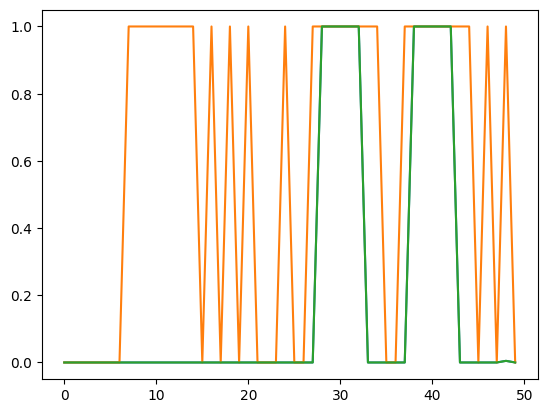

In [79]:
# plotting the first three normal data points
plt.plot(normal_train_data[0])
plt.plot(normal_train_data[1])
plt.plot(normal_train_data[2])

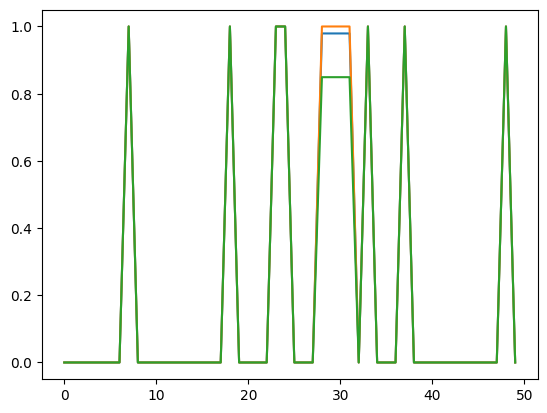

In [80]:
# plotting the first three anomaly data points
plt.plot(anomaly_train_data[0])
plt.plot(anomaly_train_data[1])
plt.plot(anomaly_train_data[2])

In [81]:
class Autoencoder(Model):
  def __init__(self):
    super(Autoencoder, self).__init__()
    self.encoder = Sequential([
                                Dense(64, activation='relu'),
                                Dense(32, activation='relu'),
                                Dense(16, activation='relu'),
                                Dense(8, activation='relu')
    ])

    self.decoder = Sequential([
                               Dense(16, activation='relu'),
                               Dense(32, activation='relu'),
                               Dense(64, activation='relu'),
                               Dense(df.shape[1] - 1, activation='sigmoid')
    ])

  def call(self,x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [82]:
# Instantiating the Autoencoder
model = Autoencoder()

# creating an early_stopping
early_stopping = EarlyStopping(monitor='val_loss',
                               patience = 2,
                               mode = 'min')

# Compiling the model
model.compile(optimizer = 'adam',
              loss = 'mae')

In [84]:
# Training the model
history = model.fit(normal_train_data,normal_train_data,
                    epochs = 50,
                    batch_size = 120,
                    validation_data = (train_data_scaled[:,1:], train_data_scaled[:,1:]),
                    shuffle = True,
                    callbacks = [early_stopping])

Epoch 1/50
2/2 [==============================] - 1s 1s/step - loss: 0.2200 - val_loss: 0.3344
Epoch 2/50
2/2 [==============================] - 1s 1s/step - loss: 0.2185 - val_loss: 0.3310
Epoch 3/50
2/2 [==============================] - 1s 1s/step - loss: 0.2171 - val_loss: 0.3263
Epoch 4/50
2/2 [==============================] - 1s 1s/step - loss: 0.2161 - val_loss: 0.3217
Epoch 5/50
2/2 [==============================] - 1s 1s/step - loss: 0.2154 - val_loss: 0.3177
Epoch 6/50
2/2 [==============================] - 1s 1s/step - loss: 0.2146 - val_loss: 0.3165
Epoch 7/50
2/2 [==============================] - 1s 1s/step - loss: 0.2130 - val_loss: 0.3159
Epoch 8/50
2/2 [==============================] - 1s 1s/step - loss: 0.2108 - val_loss: 0.3163
Epoch 9/50
2/2 [==============================] - 1s 1s/step - loss: 0.2086 - val_loss: 0.3155
Epoch 10/50
2/2 [==============================] - 1s 1s/step - loss: 0.2063 - val_loss: 0.3127
Epoch 11/50
2/2 [==============================] 

In [85]:
# predictions for normal test data points
encoder_out = model.encoder(normal_test_data).numpy()
decoder_out = model.decoder(encoder_out).numpy()

In [86]:
encoder_out.shape

(48, 8)

In [87]:
decoder_out.shape

(48, 50)

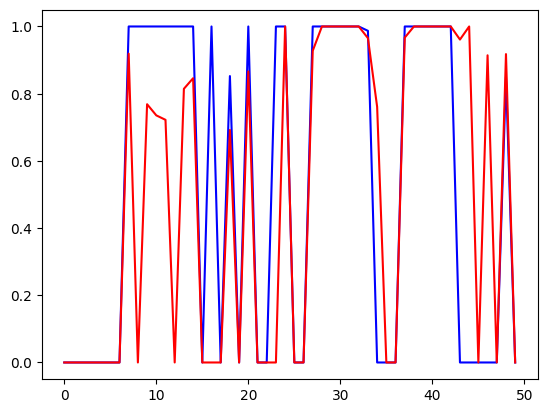

In [88]:
# plotting normal test data point and its predictiction by the autoencoder
plt.plot(normal_test_data[0], 'b')
plt.plot(decoder_out[0], 'r')

In [89]:
# predictions for anomaly test data points
encoder_out_a = model.encoder(anomaly_test_data).numpy()
decoder_out_a = model.decoder(encoder_out_a).numpy()

anomaly_scores= [[9.99984640e-01 1.12370808e-05 1.16096890e-04 ... 1.86936304e-04
  2.59719014e-01 2.35510606e-06]
 [6.71661294e-13 2.57245695e-13 1.00953489e-10 ... 2.77142642e-10
  5.47393560e-02 4.05878071e-15]
 [4.64701443e-05 3.51508716e-05 2.89719115e-04 ... 4.26619430e-04
  2.80623496e-01 8.36867366e-06]
 ...
 [3.07800583e-05 2.29524248e-05 2.07035293e-04 ... 3.08854389e-04
  2.72451818e-01 5.14893327e-06]
 [4.64701443e-05 3.51508716e-05 2.89719115e-04 ... 4.26619430e-04
  2.80623496e-01 8.36867366e-06]
 [2.88710762e-05 2.14780011e-05 1.96325433e-04 ... 2.93689081e-04
  2.71307409e-01 4.77404092e-06]]


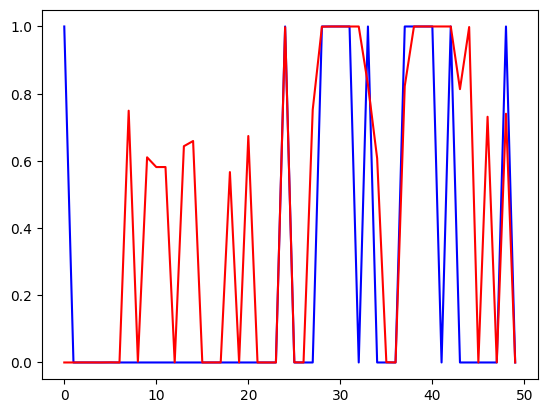

In [90]:
# plotting anomaly test data point and its predictiction by the autoencoder
plt.plot(anomaly_test_data[0], 'b')
plt.plot(decoder_out_a[0], 'r')

anomaly_scores = np.abs(anomaly_test_data - decoder_out_a)
print('anomaly_scores=', anomaly_scores)

(array([ 6.,  2.,  7.,  5.,  2., 24.,  0.,  0.,  1.,  1.]),
 array([0.09496201, 0.12031222, 0.14566242, 0.17101263, 0.19636283,
        0.22171304, 0.24706325, 0.27241345, 0.29776366, 0.32311386,
        0.34846407]),
 <BarContainer object of 10 artists>)

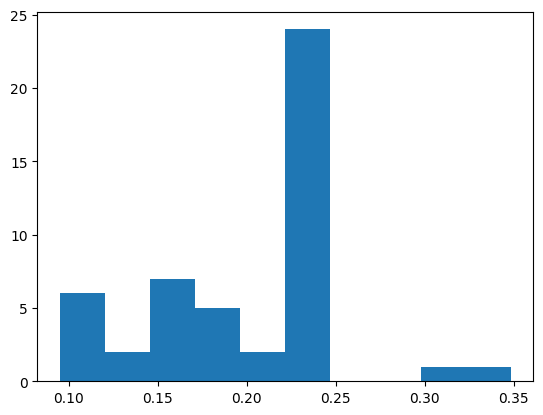

In [91]:
# reconstruction loss for normal test data
reconstructions = model.predict(normal_test_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_test_data)

# Plotting histogram for recontruction loss for normal test data
plt.hist(train_loss, bins = 10)

In [92]:
np.mean(train_loss)

0.1959962861364232

In [93]:
np.std(train_loss)

0.05628556601100738

(array([  851.,     0.,     0.,     0.,     0.,   793.,     0., 18157.,
            0.,   151.]),
 array([0.09297949, 0.12319893, 0.15341837, 0.18363781, 0.21385725,
        0.24407669, 0.27429613, 0.30451557, 0.33473501, 0.36495445,
        0.39517388]),
 <BarContainer object of 10 artists>)

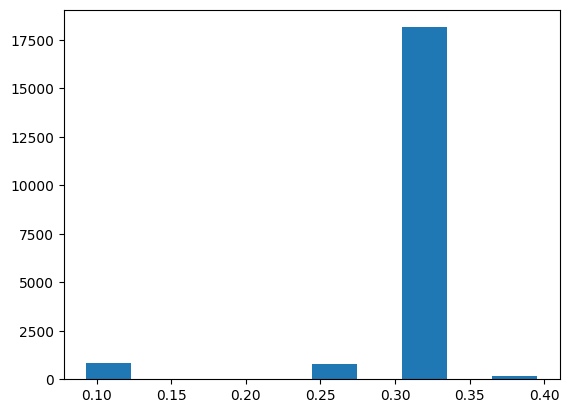

In [94]:
# reconstruction loss for anomaly test data
reconstructions_a = model.predict(anomaly_test_data)
train_loss_a = tf.keras.losses.mae(reconstructions_a, anomaly_test_data)

# Plotting histogram for recontruction loss for anomaly test data
plt.hist(train_loss_a, bins = 10)

In [95]:
np.mean(train_loss_a)

0.3131200782109395

In [96]:
np.std(train_loss_a)

0.04553183618840629

In [97]:
# setting threshold
threshold = np.mean(train_loss) + 2*np.std(train_loss)

In [98]:
threshold

0.30856741815843797

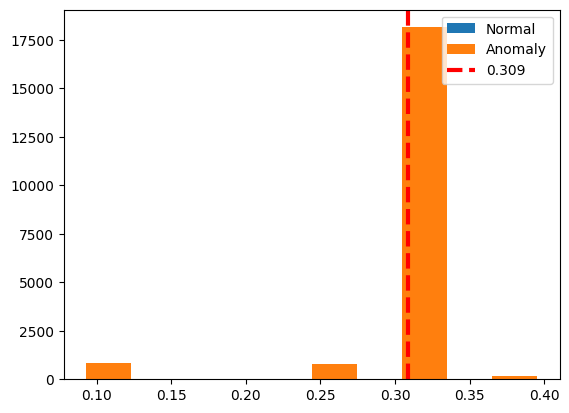

In [99]:
# Plotting the normal and anomaly losses with the threshold
plt.hist(train_loss, bins = 10, label = 'Normal')
plt.hist(train_loss_a, bins = 10, label = 'Anomaly')
plt.axvline(threshold, color='r', linewidth = 3, linestyle = 'dashed', label = '{:0.3f}'.format(threshold))
plt.legend(loc = 'upper right')
plt.show()

In [100]:
# Number of correct predictions for Normal test data  
preds = tf.math.less(train_loss, threshold)

In [101]:
tf.math.count_nonzero(preds)

<tf.Tensor: shape=(), dtype=int64, numpy=46>

In [102]:
# Number of correct predictions for Anomaly test data 
preds_a = tf.math.greater(train_loss_a, threshold)

In [103]:
tf.math.count_nonzero(preds_a)

<tf.Tensor: shape=(), dtype=int64, numpy=18308>

In [104]:
preds_a.shape

TensorShape([19952])